In [1]:
import os, glob, subprocess, datetime

import pandas as pd
import numpy as np
import pickle as pkl
import scipy.stats as stats
import properscoring as ps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scores import *
from utils import _fDepth, _fQuantile

from sklearn.neighbors import KernelDensity
from scipy.integrate import quad
from scipy import interpolate
from ipywidgets import *
from sklearn.linear_model import BayesianRidge, LinearRegression
from scipy.stats import multivariate_normal, norm
from scipy.interpolate import make_smoothing_spline
from statsmodels.distributions.empirical_distribution import ECDF

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams['font.family']         = 'Avenir'

path_to_fDepth = '/Users/Guille/Desktop/dynamic_update/functional_forecast_dynamic_update/fDepth'
path_to_data   = '/Users/Guille/Desktop/dynamic_update/data'
path_to_images = '/Users/Guille/Desktop/dynamic_update/images'

## Historical random curves

In [2]:
# Resource
resource = 'wind'

# Timestamps in interval
T = 288
n = 100

### Training dataset

In [3]:
ac_tr_  = pd.read_csv(path_to_data + '/actuals/' + resource + '_actual_5min_site_2017.csv')
ac_tr_  = ac_tr_.iloc[T:-T]
assets_ = ac_tr_.columns[1:n+1]

dates_ = ac_tr_[['Time']].to_numpy()
ac_tr_ = ac_tr_[assets_].to_numpy()
print(ac_tr_.shape)

# Normalized between 0 and 1 by Max Power
p_        = np.max(ac_tr_, axis = 0)
dates_tr_ = dates_.reshape(int(dates_.shape[0]/T), T)
F_tr_     = ac_tr_.reshape(int(ac_tr_.shape[0]/T), T, ac_tr_.shape[1])

for i in range(p_.shape[0]):
    F_tr_[..., i] /= p_[i]
print(p_.shape, dates_tr_.shape, F_tr_.shape)

F_tr_ = np.concatenate([F_tr_[..., i] for i in range(p_.shape[0])], axis = 0)
print(F_tr_.shape)

(104544, 100)
(100,) (363, 288) (363, 288, 100)
(36300, 288)


### Testing

In [4]:
ac_ts_ = pd.read_csv(path_to_data + '/actuals/' + resource + '_actual_5min_site_2018.csv')
print(ac_ts_.shape)

dates_ = ac_ts_[['Time']].to_numpy()
ac_ts_ = ac_ts_[assets_].to_numpy()
print(dates_.shape, ac_ts_.shape)

dates_ts_ = dates_.reshape(int(dates_.shape[0]/T), T)
F_ts_     = ac_ts_.reshape(int(ac_ts_.shape[0]/T), T, ac_ts_.shape[1])

# Normalized between 0 and 1 by Max Power
for i in range(p_.shape[0]):
    F_ts_[..., i] /= p_[i]
    
print(dates_ts_.shape, F_ts_.shape)

(105120, 265)
(105120, 1) (105120, 100)
(365, 288) (365, 288, 100)


## Day-ahead forecast

### Training dataset

In [5]:
# Time Zone
TZ_fc = 5

fc_                 = pd.read_csv(path_to_data + '/actuals/' + resource + '_day_ahead_forecast_2017.csv')
fc_['Forecast_time'] = fc_['Forecast_time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - datetime.timedelta(hours = TZ_fc + 0.5))
fc_                 = fc_[assets_].to_numpy()

x_fc_ = (np.linspace(0, fc_.shape[0] - 1, fc_.shape[0]) + .5)*12
x_ac_ = np.linspace(0, fc_.shape[0]*12 - 1, fc_.shape[0]*12)

E_tr_ = []
for k in range(n):
    fc_tr_ = interpolate.interp1d(x_fc_, fc_[:, k], kind = 'nearest-up', fill_value = "extrapolate")(x_ac_)

    E_tr_.append(fc_tr_.reshape(int(fc_tr_.shape[0]/T), T)[..., np.newaxis])
    
E_tr_ = np.concatenate(E_tr_, axis = 2)

# Normalized between 0 and 1 by Max Power
for a in range(p_.shape[0]): 
    E_tr_[..., a] /= p_[a] 
print(E_tr_.min(), E_tr_.max())

E_tr_[E_tr_ > 1.] = 1.
E_tr_[E_tr_ < 0.] = 0.
print(E_tr_.shape)

E_tr_ = np.concatenate([E_tr_[..., i] for i in range(p_.shape[0])], axis = 0)
print(E_tr_.shape)

0.0 0.9999999888984702
(363, 288, 100)
(36300, 288)


### Testing dataset

In [6]:
# Time Zone
TZ_fc = 6

fc_                 = pd.read_csv(path_to_data + '/actuals/' + resource + '_day_ahead_forecast_2018.csv', index_col = None)
fc_['horizon_time'] = fc_['horizon_time'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%y %H:%M') - datetime.timedelta(hours = TZ_fc + 0.5))
fc_                 = fc_[assets_].to_numpy()

x_fc_ = (np.linspace(0, fc_.shape[0] - 1, fc_.shape[0]) + .5)*12
x_ac_ = np.linspace(0, fc_.shape[0]*12 - 1, fc_.shape[0]*12)

E_ts_ = []
for k in range(n):
    fc_ts_ = interpolate.interp1d(x_fc_, fc_[:, k], kind = 'nearest-up', fill_value = "extrapolate")(x_ac_)

    E_ts_.append(fc_ts_.reshape(int(fc_ts_.shape[0]/T), T)[..., np.newaxis])
    
E_ts_ = np.concatenate(E_ts_, axis = 2)

# Normalized between 0 and 1 by Max Power
for a in range(p_.shape[0]): 
    E_ts_[..., a] /= p_[a] 
print(E_ts_.min(), E_ts_.max())

E_ts_[E_ts_ > 1.] = 1.
E_ts_[E_ts_ < 0.] = 0.
print(E_ts_.shape)

# E_ts_ = np.concatenate([F_fc_ts_[..., i] for i in range(p_.shape[0])], axis = 0)
# print(E_ts_.shape)

0.0 1.1040452459380494
(365, 288, 100)


# Functional k-NNs

In [7]:
# Calculate weighted (w_) distance between X_ and x_
def _dist(X_, x_, w_ = []):
    if len(w_) == 0:
        w_ = np.ones(x_.shape)
    w_ = w_/w_.sum()
    d_ = np.zeros((X_.shape[0], ))
    for i in range(X_.shape[0]):
        d_[i] = w_.T @ (X_[i, :] - x_)**2
    return d_

# Radial Basis function kernel based on distance (d_)
def _kernel(d_, length_scale):
    w_ = np.exp(-d_/length_scale)
    return w_/w_.sum()

def _inv_dist(d_, length_scale):
    w_ = 1./(d_ + length_scale)
    return w_/w_.sum()

# Define exponential growth function
def _exponential_growth(t, dacay_rate, innit = 0):
    tau_ = np.linspace(t - 1, 0, t)
    return np.exp(-dacay_rate*tau_)

# Define exponential dacay function
def _exponential_decay(S, dacay_rate):
    s_ = np.linspace(0, S - 1, S)
    return np.exp(-dacay_rate*s_)

# Fuse day-ahead forecast with real-time forecast
def _update_forecast(F_ac_, f_hat_, fc_, update_rate):

    w_update_ = 1. - _exponential_decay_plus(F_ac_.shape[1] + 1, update_rate)[1:]
    #w_update_ = eta_/eta_.max()
    f_update_ = f_hat_*(1. - w_update_) + fc_*w_update_

    plt.figure(figsize = (10, 2))
    plt.title('Trust Rate')
    plt.plot(w_update_)
    plt.show()

    return f_update_

# Define a function to calculate quantiles
def _KDE_quantile(_KDE, q_, x_min     = 0., 
                            x_max     = 1., 
                            n_samples = 1000):
    
    """
    Calculates the quantile for a given probability using KDE.

    Parameters:
    _KDE: Kernel density estimate object (e.g., from scipy.stats.gaussian_kde).
    q:    Probability value (between 0 and 1) for which to calculate the quantile.

    Returns:
    The quantile value.
    """

    # Calculate CDF
    x_ = np.linspace(x_min, x_max, n_samples)
    #z_ = np.exp(_KDE.score_samples(x_[:, np.newaxis]))
    w_ = np.cumsum(np.exp(_KDE.score_samples(x_[:, np.newaxis])))
    # Normalize CDF
    w_ /= w_[-1] 
    
    return np.interp(np.array(q_), w_, x_), np.interp(1. - np.array(q_), w_, x_)


# Silverman's Rule
def _silverman_rule(x_):
    IQR = np.percentile(x_, 75) - np.percentile(x_, 25)
    return 0.9 * min(np.std(x_), IQR / 1.34) * x_.shape[0] ** (-1/5)

(144,) (144,) (288,)
144 288
1.4908281870125649e-50
(36300,) (36300,)


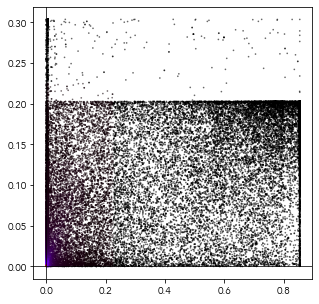

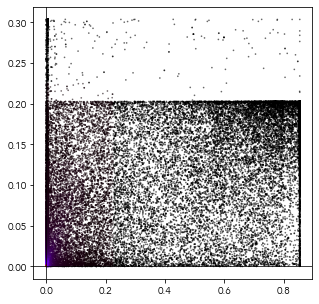

3173


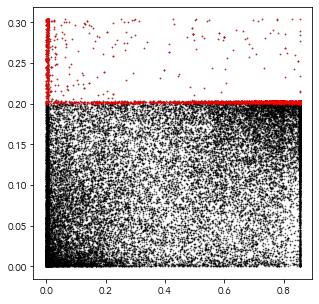

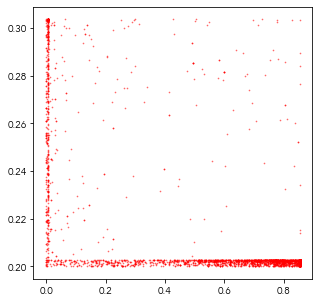

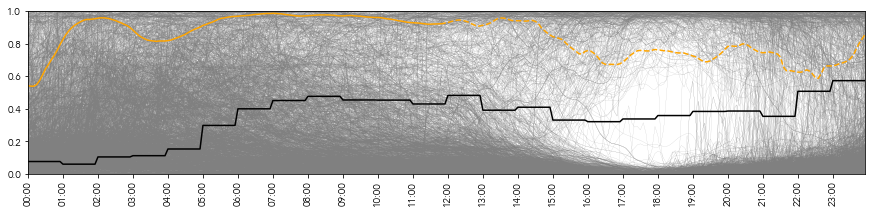

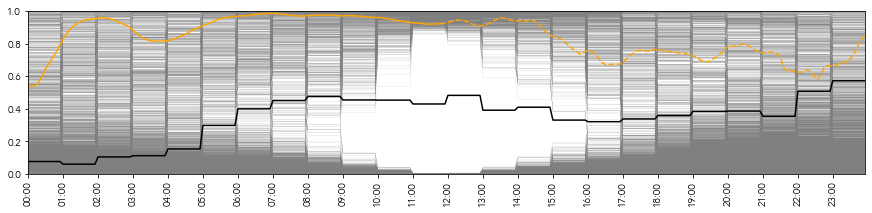

NameError: name 'x' is not defined

In [79]:
a = 0
d = 9
t = 12*12

f_     = F_ts_[d, :t, a]
f_hat_ = F_ts_[d, t:, a]
e_     = E_ts_[d, :, a]
print(f_.shape, f_hat_.shape, e_.shape)

forget_rate  = 1.
trust_rate   = .1
length_scale = .001

T = E_ts_.shape[1]
t = f_.shape[0]
print(t, T)
    
dt_ = np.array([t*5 for t in range(T)])
dx_ = pd.to_datetime(pd.DataFrame({'time': dt_}).time, unit = 'm').dt.strftime('%H:%M').to_numpy()

tau_ = dt_[:t]
s_   = dt_[t:]


e = np.exp(-2.*np.sum((f_ - e_[:t])**2))

# phi: importance weights based on time distance
phi_ = _exponential_growth(t, forget_rate)
psi_ = np.exp(-trust_rate*np.absolute(dt_ - t*5 + 5))
eta_ = 1. - _exponential_decay(T - t, e)

# d: euclidian distance between samples weighted by importance weights (phi)
d_F_  = _dist(F_tr_[:, :t], f_, w_ = phi_)

d_E_1_  = _dist(E_tr_, e_, w_ = psi_)


print(e)
# d_E_1_  = _dist(E_tr_[:, :t], e_[:t])
# d_E_1_ /= d_E_1_.std()

print(d_F_.shape, d_E_1_.shape)

# d_F_p_ = d_F_/d_F_.std()

# d_E_p_ = d_E_1_/d_E_1_.std()

d_ = np.max(np.stack([d_F_, d_E_1_]), axis = 0)
#d_ = d_E_p_

w_    = _inv_dist(d_, length_scale)
_cmap = plt.get_cmap('gnuplot')
_norm = plt.Normalize(w_.min(), w_.max())
c_    = _cmap(_norm(w_))

plt.figure(figsize = (5, 5))
plt.scatter(d_F_, d_E_1_, c = c_, s = 0.5, alpha = 0.5)
plt.axvline(0, color = 'k', linewidth = .75)
plt.axhline(0, color = 'k', linewidth = .75)
plt.show()


#d_ = np.sum(np.stack([d_F_p_**2, d_E_p_**2]), axis = 0)

w_    = _inv_dist(d_, length_scale)
_cmap = plt.get_cmap('gnuplot')
_norm = plt.Normalize(w_.min(), w_.max())
c_    = _cmap(_norm(w_))

plt.figure(figsize = (5, 5))
plt.scatter(d_F_, d_E_1_, c = c_, s = 0.5, alpha = 0.5)
plt.axvline(0, color = 'k', linewidth = .75)
plt.axhline(0, color = 'k', linewidth = .75)
plt.show()


idx_ = (d_E_1_ > 0.2) 
print(idx_.sum())


plt.figure(figsize = (5, 5))
plt.scatter(d_F_, d_E_1_, c = 'k', s = 0.5, alpha = 0.5)
plt.scatter(d_F_[idx_], d_E_1_[idx_], c = 'r', s = 0.5, alpha = 0.5)
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(d_F_[idx_], d_E_1_[idx_], c = 'r', s = 0.5, alpha = 0.5)
plt.show()

plt.figure(figsize = (15, 3))
for i in np.linspace(0, F_tr_.shape[0] - 1, F_tr_.shape[0], dtype = int)[idx_]:
    plt.plot(dt_, F_tr_[i, :], c = 'gray', lw =0.1)
plt.plot(tau_, f_, c = 'orange', label = 'ac')
plt.plot(s_, f_hat_, c = 'orange', ls = '--')
plt.plot(dt_, e_, c = 'k', label = 'fc')
plt.xticks(dt_[::12], dx_[::12], rotation = 90)
plt.ylim(-0., 1.)
plt.xlim(dt_[0], dt_[-1])
plt.show()

plt.figure(figsize = (15, 3))
for i in np.linspace(0, E_tr_.shape[0] - 1, E_tr_.shape[0], dtype = int)[idx_]:
    plt.plot(dt_, E_tr_[i, :], c = 'gray', lw =0.1)
plt.plot(tau_, f_, c = 'orange', label = 'ac')
plt.plot(s_, f_hat_, c = 'orange', ls = '--')
plt.plot(dt_, e_, c = 'k', label = 'fc')
plt.xticks(dt_[::12], dx_[::12], rotation = 90)
plt.ylim(-0., 1.)
plt.xlim(dt_[0], dt_[-1])
plt.show()
x

# w: normalized wieghts distance across observations based on RBF kernel distance
#w_ = _kernel(d_, _model['length_scale'])


#idx_ = _model['weights'] > 0.
xi_  = 1. - np.cumsum(w_[np.argsort(w_)[::-1]])
idx_ = xi_ > 0.9
kappa = idx_.sum()
print(idx_.sum())
print(xi_[idx_.sum()])

plt.figure()
plt.plot(xi_)
plt.axvline(idx_.sum(), color = 'k', linewidth = .75)
plt.axhline(xi_[idx_.sum()], color = 'k', linewidth = .75)
plt.show()

idx_ = np.argsort(w_)[-kappa:]
mu_  = np.zeros((idx_.shape[0], T - t))
for i, j in zip(idx_, range(idx_.shape[0])):
    mu_[j, :] = F_tr_[i, t:]*(1. - eta_) + E_tr_[i, t:]*eta_

plt.figure(figsize = (15, 3))
plt.plot(tau_, f_, c = 'orange', label = 'ac')
plt.plot(s_, f_hat_, c = 'orange', ls = '--')
plt.plot(dt_, e_, c = 'k', label = 'fc')
plt.fill_between(tau_, np.ones(tau_.shape), np.zeros(tau_.shape), color = 'lightgray', alpha = .5)
plt.axvline(dt_[t - 1], color = 'k', linewidth = 1., label = 'up (event)')
plt.plot(tau_, phi_, c = 'r', lw = 1.) 
plt.plot(dt_, psi_, c = 'g', lw = 1.)  
plt.plot(s_, eta_, c = 'b', lw = 1.)
plt.xticks(dt_[::12], dx_[::12], rotation = 90)
plt.ylim(-0., 1.)
plt.xlim(dt_[0], dt_[-1])
plt.ylabel('Capacity Factor')
plt.legend(frameon = False)
plt.show()

_cmap = plt.get_cmap('gnuplot')
_norm = plt.Normalize(w_[idx_[0]], w_[idx_[-1]])
c_    = _cmap(_norm(w_))

plt.figure(figsize = (15, 3))
for i in idx_:
    plt.plot(tau_, E_tr_[:, :t][i, :], c = c_[i], lw = .5) 
    plt.plot(s_, E_tr_[:, t:][i, :], c = c_[i], lw = .5) 
plt.fill_between(tau_, np.ones(tau_.shape), np.zeros(tau_.shape), color = 'lightgray', alpha = .5)
plt.axvline(dt_[t - 1], color = 'k', linewidth = 1., label = 'event (fc)')
plt.xticks(dt_[::12], dx_[::12], rotation = 90)
plt.ylim(-0., 1.)
plt.xlim(dt_[0], dt_[-1])
plt.show()

plt.figure(figsize = (15, 3))
for i in idx_:
    plt.plot(dt_, F_tr_[i, :], c = c_[i], lw = .5) 
plt.fill_between(tau_, np.ones(tau_.shape), np.zeros(tau_.shape), color = 'lightgray', alpha = .5)
plt.axvline(dt_[t - 1], color = 'k', linewidth = 1., label = 'event (fc)')
plt.xticks(dt_[::12], dx_[::12], rotation = 90)
plt.ylim(-0., 1.)
plt.xlim(dt_[0], dt_[-1])
plt.show()


Z_ = []
for i in range(t, T, 1):
    a_, b_ = np.histogram(F_tr_[idx_, i], bins = 20, range = (0, 1), density = True)
    Z_.append(a_)
    
Z_     = np.stack(Z_).T
X_, Y_ = np.meshgrid(dt_[t:], (b_[1:] + b_[:-1])/2.)

plt.figure(figsize = (15, 3))
plt.pcolormesh(X_, Y_, Z_, cmap = 'coolwarm')

plt.plot(tau_, f_, c = 'orange', label = '(ac)')
plt.plot(s_, f_hat_, c = 'orange', ls = '--')
plt.plot(dt_, e_, c = 'k', label = 'Day-ahead (fc)')
plt.fill_between(tau_, np.ones(tau_.shape), np.zeros(tau_.shape), color = 'lightgray', alpha = .5)
plt.axvline(dt_[t - 1], color = 'k', linewidth = 1., label = 'event (fc)')

plt.axvline(dt_[t + 1], color = 'k', lw = .75, ls = '--')
plt.axvline(dt_[t + 6], color = 'k', lw = .75, ls = '--')
plt.axvline(dt_[t + 18], color = 'k', lw = .75, ls = '--')
plt.axvline(dt_[t + 54], color = 'k', lw = .75, ls = '--')
#plt.axvline(dt_[t + 16], color = 'k', lw = .5, ls = '--')
#plt.axvline(dt_[t + 96], color = 'k', lw = 1., ls = '--')

plt.xticks(dt_[::12], dx_[::12], rotation = 90)

plt.ylabel('Capacity Factor')

plt.ylim(0., 1.)
plt.xlim(dt_[0], dt_[-1])
plt.show()

In [43]:
print(mu_.shape)
depth_ = _fQuantile(mu_, path_to_fDepth)
print(depth_)

(379, 144)
        DQ_60     DQ_80     DQ_90     DQ_95
0    1.798699  1.337167  1.193455  1.168342
1    1.166973  0.692436  0.555253  0.496708
2    1.166973  0.692436  0.555253  0.496708
3    0.876902  0.593951  0.471690  0.421344
4    2.134294  1.532318  1.080853  0.838873
..        ...       ...       ...       ...
374  1.120631  0.978360  0.870372  0.809245
375  4.181711  2.474272  1.990174  1.521856
376  4.181711  2.474272  1.990174  1.521856
377  1.124339  0.713041  0.639228  0.605108
378  1.124339  0.713041  0.639228  0.605108

[379 rows x 4 columns]


In [54]:
idx_ = depth_.to_numpy()[:, 0] < 1.
print(idx_.sum())

9


In [232]:
# # Define functional forecast model and functional observations
# def _fit(F_, E_, 
#          forget_rate  = 1e6,
#          trust_rate   = 0,
#          length_scale = 100, 
#          rho          = 0.99,
#          thr_kNNs     = 0.01,
#          n_kNNs       = 0,
#          n_min_kNNs   = 5,
#          n_max_kNNs   = 50):
    
#     _model = {}
    
#     _model['F(t)'] = F_
#     _model['E(t)'] = E_
#     _model['T']    = _model['F(t)'].shape[1]

#     # Forget rate:
#     # 0 - weight equal to the all past obervation time series 
#     # 1 - full weight on the most recent observations
#     _model['forget_rate'] = forget_rate
    
#     # Thrust rate to day-ahead forecast:
#     # 0 - Don't trust the day-head forecast
#     # 1 - Trust the day-ahead forecast fully
#     _model['trust_rate'] = trust_rate
    
#     # Kernel based distance lenght-scale parameter:
#     # lenght-scale: smaller lenght-scale weights heavier closest samples
#     _model['length_scale'] = length_scale

#     # Day-ahead forecast vs curve's collection distances
#     _model['rho'] = rho
    
#     # Predictive kernel desnity estimator (KDE) bandwith
#     #_model['eta'] = bandwith

#     # Number of k nearest neighbors (n_kNNs or tr_kNNs)
#     # kapppa: Force n to be k
#     # xi: Adaptive thershold by weight probability
#     # * kappa_min: minimim number of neightbors when applied xi
#     # * kappa_max: maximum number of neightbors when applied xi
#     # uniform_kNNs: True selected samples weights uniform, False distance based kernel wegihts
#     _model['kappa']     = n_kNNs
#     _model['xi']        = thr_kNNs
#     _model['kappa_min'] = n_min_kNNs

#     return _model

In [71]:
# # Forecast dynamic update based on functional kNNs
# def _predict(_model, f_, e_, f_hat_):
                
#     t = f_.shape[0]
    
#     dt_ = np.array([t*5 for t in range(_model['T'])])
#     dx_ = pd.to_datetime(pd.DataFrame({'time': dt_}).time, unit = 'm').dt.strftime('%H:%M').to_numpy()

#     _model['f(tau)'] = f_
    
#     _model['e(tau)'] = e_[:t]
#     _model['e(s)']   = e_[t:]

#     _model['F(tau)'] = _model['F(t)'][:, :t]
#     _model['E(tau)'] = _model['E(t)'][:, :t]
    
#     _model['F(s)'] = _model['F(t)'][:, t:]
#     _model['E(s)'] = _model['E(t)'][:, t:]

#     # phi: importance weights based on time distance
#     _model['phi(tau)'] = _exponential_growth(t, _model['forget_rate'])
    
#     _model['psi(t)'] = np.exp(-_model['trust_rate']*np.absolute(dt_ - t*5 + 5))

#     plt.figure(figsize = (10, 2))
#     plt.title('Forget Rate')
#     plt.plot(dt_, _model['psi(t)'])
#     #plt.ylim(-0.1,1.1)
#     plt.show()
    
    
    
#     # plt.figure(figsize = (10, 2))
#     # plt.title('Trust Rate')
#     # plt.plot(phi_plus_)
#     # plt.ylim(-0.1,1.1)
#     # plt.show()
    
#     #k = _model['n_kNNs']
    
#     # error = np.mean((_model['f(tau)'] - _model['e(tau)'])**2)

#     # d: euclidian distance between samples weighted by importance weights (phi)
#     d_F_ = _dist(_model['F(tau)'], _model['f(tau)'], w_ = _model['phi(tau)'])
#     d_E_ = _dist(_model['E(t)'], e_, w_ = _model['psi(t)'])
#     print(d_F_.shape, d_E_.shape)

#     d_F_ /= d_F_.std()
#     d_E_ /= d_E_.std()

#     d_ = np.max(np.stack([d_F_**2, d_E_**2]), axis = 0)

#     w_ = _inv_dist(d_, _model['length_scale'])
    
#     _cmap = plt.get_cmap('inferno')
#     _norm = plt.Normalize(w_.min(), w_.max())
#     c_    = _cmap(_norm(w_))
    
#     plt.figure(figsize = (5, 5))
#     plt.scatter(d_F_, d_E_, c = c_, s = 0.5, alpha = 0.5)
#     # plt.ylim(-1, 1)
#     # plt.xlim(-1, 1)
#     plt.show()


#     # w: normalized wieghts distance across observations based on RBF kernel distance
#     #w_ = _kernel(d_, _model['length_scale'])
    
        

#     #idx_ = _model['weights'] > 0.
#     xi_  = 1. - np.cumsum(w_[np.argsort(w_)[::-1]])
#     idx_ = xi_ > _model['xi']
#     #print(idx_.sum())
#     #_model['kappa'] = idx_.sum()
#     #print(xi_[idx_.sum()])
#     plt.figure()
#     plt.plot(xi_)
#     plt.show()
    
#     idx_ = np.argsort(w_)[-_model['kappa']:]
#     #print(idx_.shape, idx_.sum(), _model['F_ts_'].shape, F_hat_.shape)
#     #F_hat_[_model['weights'] > 0.]
#     #F_tr_p_ = _model['F_tr_'][_model['weights'] > 0.]

#     tau_ = dt_[:t]
#     s_   = dt_[t:]
        
#     plt.figure(figsize = (15, 3))
#     plt.plot(tau_, _model['f(tau)'], c = 'b', label = 'CF (ac)')
#     plt.plot(s_, f_hat_, c = 'b', ls = '--')
#     #plt.plot(dt_, np.mean(_model['F(t)'], axis = 0), c = 'yellow', label = r'ave($\mathcal{F}$)')
#     plt.plot(dt_, e_, c = 'k', label = 'Day-ahead CF (fc)')
#     plt.fill_between(tau_, np.ones(tau_.shape), np.zeros(tau_.shape), color = 'lightgray', alpha = .5)
#     plt.axvline(dt_[t - 1], color = 'k', linewidth = 1., label = 'event (fc)')
#     plt.plot(tau_, _model['phi(tau)'], c = 'r', lw = 1., label = r'Forget Rate ($\varepsilon = {}$)'.format(_model['forget_rate'])) 
#     plt.plot(dt_, _model['psi(t)'], c = 'g', lw = 1., label = r'Trust Rate ($\alpha = {}$)'.format(_model['trust_rate']))  
#     plt.xticks(dt_[::12], dx_[::12], rotation = 90)
#     plt.ylim(-0., 1.)
#     plt.xlim(dt_[0], dt_[-1])
#     plt.legend(frameon = False)

# #     plt.savefig(path_to_images + r'/param_12.pdf', 
# #                 bbox_inches = 'tight', 
# #                 dpi         = 300)
    
#     plt.show()

#     _cmap = plt.get_cmap('inferno')
#     _norm = plt.Normalize(w_[idx_[0]], w_[idx_[-1]])
#     c_    = _cmap(_norm(w_))
    
#     plt.figure(figsize = (15, 3))
#     for i in idx_:
#         plt.plot(tau_, _model['E(tau)'][i, :], c = c_[i], lw = .5) 
#         plt.plot(s_, _model['E(s)'][i, :], c = c_[i], lw = .5) 

#     plt.fill_between(tau_, np.ones(tau_.shape), np.zeros(tau_.shape), color = 'lightgray', alpha = .5)
#     plt.axvline(dt_[t - 1], color = 'k', linewidth = 1., label = 'event (fc)')
#     plt.xticks(dt_[::12], dx_[::12], rotation = 90)
#     plt.ylim(-0., 1.)
#     plt.xlim(dt_[0], dt_[-1])
    
#     plt.show()
    
#     plt.figure(figsize = (15, 3))
#     for i in idx_:
#         plt.plot(dt_, _model['F(t)'][i, :], c = c_[i], lw = .5) 

#     plt.fill_between(tau_, np.ones(tau_.shape), np.zeros(tau_.shape), color = 'lightgray', alpha = .5)
#     plt.axvline(dt_[t - 1], color = 'k', linewidth = 1., label = 'event (fc)')
#     plt.xticks(dt_[::12], dx_[::12], rotation = 90)
#     plt.ylim(-0., 1.)
#     plt.xlim(dt_[0], dt_[-1])
    
#     plt.show()
    

#     return _model


# _model = _fit(F_tr_, E_tr_, 
#               forget_rate  = 1.,
#               trust_rate   = .1,
#               length_scale = .005, 
#               rho          = .1,
#               n_kNNs       = 50)

# a = 0
# d = 9
# t = 12*12

# f_     = F_ts_[d, :t, a]
# f_hat_ = F_ts_[d, t:, a]
# e_     = E_ts_[d, :, a]
# print(f_.shape, f_hat_.shape, e_.shape)

# _model = _predict(_model, f_, e_, f_hat_)


(144,) (144,) (288,)


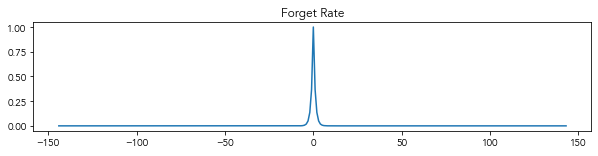

(36300,) (36300,)


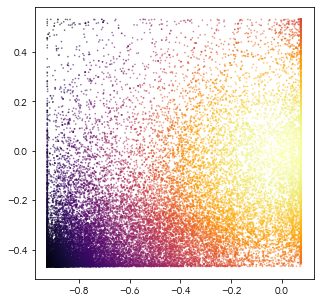

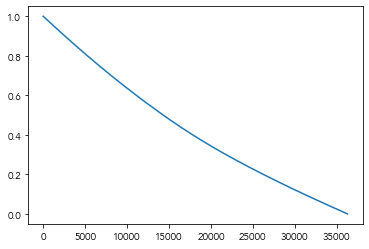

KeyError: 'phi(s)'

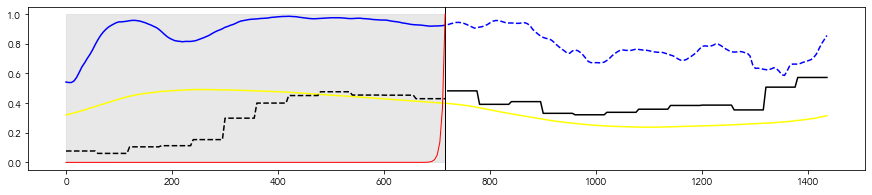

In [214]:
# Forecast dynamic update based on functional kNNs
def _predict(_model, f_, e_, f_hat_):
                
    t = f_.shape[0]
    
    _model['f(tau)'] = f_
    
    _model['e(tau)'] = e_[:t]
    _model['e(s)']   = e_[t:]

    _model['F(tau)'] = _model['F(t)'][:, :t]
    _model['E(tau)'] = _model['E(t)'][:, :t]
    
    _model['F(s)'] = _model['F(t)'][:, t:]
    _model['E(s)'] = _model['E(t)'][:, t:]

    # phi: importance weights based on time distance
    _model['phi(tau)'] = _exponential_decay_tau(t, _model['forget_rate'])

    s_ = np.linspace(0, _model['T'] - 1, _model['T']) - t
    plt.figure(figsize = (10, 2))
    plt.title('Forget Rate')
    plt.plot(s_, np.exp(-_model['trust_rate']*np.absolute(s_)))
    #plt.ylim(-0.1,1.1)
    plt.show()
    
    
    _model['psi(t)'] = np.exp(-_model['trust_rate']*np.absolute(s_))
    
    # plt.figure(figsize = (10, 2))
    # plt.title('Trust Rate')
    # plt.plot(phi_plus_)
    # plt.ylim(-0.1,1.1)
    # plt.show()
    
    #k = _model['n_kNNs']
    
    error = np.mean((_model['f(tau)'] - _model['e(tau)'])**2)

    # d: euclidian distance between samples weighted by importance weights (phi)
    d_F_ = _dist(_model['F(tau)'], _model['f(tau)'], w_ = _model['phi(tau)'])
    d_E_ = _dist(_model['E(t)'], e_, w_ = _model['psi(t)'])
    print(d_F_.shape, d_E_.shape)

    #d_ = np.max(np.stack([d_F_**2, d_E_**2]), axis = 0)
    d_ = d_F_**2 + d_E_**2
    w_ = _inv_dist(d_, _model['length_scale'])

    _cmap = plt.get_cmap('inferno')
    _norm = plt.Normalize(w_.min(), w_.max())
    c_    = _cmap(_norm(w_))
    
    plt.figure(figsize = (5, 5))
    plt.scatter(d_F_, d_E_, c = c_, s = 0.5, alpha = 0.5)
    # plt.ylim(-1, 1)
    # plt.xlim(-1, 1)
    plt.show()


    d_F_ = _inv_dist(d_F_, _model['length_scale'])

    d_E_ = _inv_dist(d_E_, _model['length_scale'])


    # w: normalized wieghts distance across observations based on RBF kernel distance
    #w_ = _kernel(d_, _model['length_scale'])
    
        
#     # If no k-Nearest Neibors use adaptative approach
#     if _model['n_kNNs'] == 0:
#         # Find the kNNs 
#         i    = int(np.sum(np.cumsum(np.sort(w_)[::-1]) < _model['tr_kNNs']))
#         idx_nn_ = w_ > np.sort(w_)[::-1][i]
#         # Enforce upper (max) and lower (min) Nearest Neibors limit
#         if (idx_nn_.sum() < _model['n_min_kNNs']):
#             idx_nn_ = w_ > np.sort(w_)[-_model['n_min_kNNs'] - 1]
#         if (idx_nn_.sum() > _model['n_max_kNNs']):
#             idx_nn_ = w_ > np.sort(w_)[-_model['n_max_kNNs'] - 1]      
#     else:
#         k = _model['n_kNNs'] + 1
#         # Find the kNNs 
#         idx_nn_ = w_.argsort().argsort() > w_.shape[0] - k
#         # Get equivalent threshold
#         tr_kNNs = w_[idx_nn_].min()

#     # Calculate kNNs weights
#     w_knn_            = np.zeros((idx_nn_.shape[0],))
#     w_knn_[idx_nn_]   = 1.
#     _model['weights'] = w_knn_/w_knn_.sum()
    

    #idx_ = _model['weights'] > 0.
    xi_  = 1. - np.cumsum(w_[np.argsort(w_)[::-1]])
    idx_ = xi_ > _model['xi']
    #print(idx_.sum())
    #_model['kappa'] = idx_.sum()
    #print(xi_[idx_.sum()])
    plt.figure()
    plt.plot(xi_)
    plt.show()
    
    idx_ = np.argsort(w_)[-_model['kappa']:]
    #print(idx_.shape, idx_.sum(), _model['F_ts_'].shape, F_hat_.shape)
    #F_hat_[_model['weights'] > 0.]
    #F_tr_p_ = _model['F_tr_'][_model['weights'] > 0.]
    
    
    dt_ = np.array([t*5 for t in range(_model['T'])])
    dx_ = pd.to_datetime(pd.DataFrame({'time': dt_}).time, unit = 'm').dt.strftime('%H:%M').to_numpy()

    tau_ = dt_[:t]
    s_   = dt_[t:]
    
    plt.figure(figsize = (15, 3))
    plt.plot(tau_, _model['f(tau)'], c = 'b', label = 'CF (ac)')
    plt.plot(s_, f_hat_, c = 'b', ls = '--')
    plt.plot(dt_, np.mean(_model['F(t)'], axis = 0), c = 'yellow', label = r'ave($\mathcal{F}$)')
    plt.plot(tau_, _model['e(tau)'], c = 'k', ls = '--')
    plt.plot(s_, _model['e(s)'], c = 'k', label = 'Day-ahead CF (fc)')
    plt.fill_between(tau_, np.ones(tau_.shape), np.zeros(tau_.shape), color = 'lightgray', alpha = .5)
    plt.axvline(dt_[t - 1], color = 'k', linewidth = 1., label = 'event (fc)')
    plt.plot(tau_, _model['phi(tau)'], c = 'r', lw = 1., label = r'Forget Rate ($\varepsilon = {}$)'.format(_model['forget_rate'])) 
    plt.plot(s_, _model['phi(s)'], c = 'g', lw = 1., label = r'Trust Rate ($\alpha = {}$)'.format(_model['trust_rate']))  
    plt.xticks(dt_[::12], dx_[::12], rotation = 90)
    plt.ylim(-0., 1.)
    plt.xlim(dt_[0], dt_[-1])
    plt.legend(frameon = False)

#     plt.savefig(path_to_images + r'/param_12.pdf', 
#                 bbox_inches = 'tight', 
#                 dpi         = 300)
    
    plt.show()
    
    _cmap = plt.get_cmap('gist_gray')
    _norm = plt.Normalize(w_[idx_[0]], w_[idx_[-1]])
    c_    = _cmap(_norm(w_))
    
    d_E_ /= d_E_[idx_].max()

    plt.figure(figsize = (15, 3))
    for i in idx_:
        # plt.plot(tau_, _model['E(tau)'][i, :], c = 'gray', lw = .5, alpha = d_E_[i]) 
        # plt.plot(s_, _model['E(s)'][i, :], c = 'gray', lw = .5, alpha = d_E_[i]) 
        plt.plot(dt_[:t], _model['F_hat_tr_'][i, :], c = 'gray', lw = .5)  
        plt.plot(dt_[t:], _model['F_hat_ts_'][i, :], c = 'gray', lw = .5) 
    plt.fill_between(tau_, np.ones(tau_.shape), np.zeros(tau_.shape), color = 'lightgray', alpha = .5)
    plt.axvline(dt_[t - 1], color = 'k', linewidth = 1., label = 'event (fc)')
    plt.xticks(dt_[::12], dx_[::12], rotation = 90)
    plt.ylim(-0., 1.)
    plt.xlim(dt_[0], dt_[-1])
    plt.title(r'$\hat{f}_{\kappa}(s)$')
    
    plt.savefig(path_to_images + r'/f_hat_12.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    plt.show()
    

    # _cmap = plt.get_cmap('inferno')
    # _norm = plt.Normalize(d_F_[idx_[0]], d_F_[idx_[-1]].max())
    # c_    = _cmap(_norm(d_F_))
    
    d_F_ /= d_F_[idx_].max()
    
    plt.figure(figsize = (15, 3))
    for i in idx_:
        plt.plot(tau_, _model['F(tau)'][i, :], c = 'gray', lw = .5, alpha = d_F_[i])  
        plt.plot(s_, _model['F(s)'][i, :], c = 'gray', lw = .5, alpha = d_F_[i]) 
        #plt.plot(dt_[t:], _model['F_ts_'][i, :], c = 'gray', lw = .5)  
        #plt.plot(dt_[:t], _model['F_tr_'][i, :], c = 'gray', lw = .5)  
    plt.fill_between(tau_, np.ones(tau_.shape), np.zeros(tau_.shape), color = 'lightgray', alpha = .5)
    plt.axvline(dt_[t - 1], color = 'k', linewidth = 1., label = 'event (fc)')   
    plt.xticks(dt_[::12], dx_[::12], rotation = 90)
    plt.ylim(-0., 1.)
    plt.xlim(dt_[0], dt_[-1])
    plt.title(r'$f_{\kappa}(s)$')
    
    plt.savefig(path_to_images + r'/f_12.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    plt.show()
    

#     _cmap = plt.get_cmap('inferno')
#     _norm = plt.Normalize(w_[idx_[0]], w_[idx_[-1]].max())
#     c_    = _cmap(_norm(w_))

    w_ /= w_[idx_].max()
    
    plt.figure(figsize = (15, 3))
    error_ = np.zeros(_model['F(s)'].shape)
    for i in idx_:
        error_[i, :] = _model['F(s)'][i, :] - _model['E(s)'][i, :]
        #plt.plot(dt_[t:], error_*phi_plus_, c = 'gray', lw = .5)  
        plt.plot(s_, error_[i, :]*_model['phi(s)'], c = 'gray', lw = .5, alpha = w_[i])  

    plt.plot(tau_, _model['f(tau)'], c = 'b', label = 'CF (ac)')
    plt.plot(s_, f_hat_, c = 'b', ls = '--')
    #plt.plot(dt_, np.concatenate([f_hat_tr_, f_hat_ts_], axis = 0), c = 'k', label = 'Day-ahead CF (fc)')
    plt.plot(tau_, _model['e(tau)'], c = 'k', ls = '--')
    plt.plot(s_, _model['e(s)'], c = 'k', label = 'Day-ahead CF (fc)')
    plt.fill_between(tau_, np.ones(tau_.shape), - np.ones(tau_.shape), color = 'lightgray', alpha = .5)
    plt.axvline(dt_[t - 1], color = 'k', linewidth = 1., label = 'event (fc)')
    plt.xticks(dt_[::12], dx_[::12], rotation = 90)
    plt.ylim(-1., 1.)
    plt.xlim(dt_[0], dt_[-1])
    plt.title(r'$(f_{\kappa}(s) - \hat{f}_{\kappa}(s))\cdot \rho_0 e^{-\alpha (s - t)}$')
    
    plt.savefig(path_to_images + r'/error_12.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    plt.show()
        
    _model['mu(s)'] = np.zeros((idx_.shape[0], _model['T'] - t))

    for i,j in zip(idx_, range(idx_.shape[0])):
        _model['mu(s)'][j, :] = _model['F(s)'][i, :]*(1. - _model['phi(s)']) + _model['E(s)'][i, :]*_model['phi(s)']
        
    plt.figure(figsize = (15, 3))
    for i,j in zip(idx_, range(_model['mu(s)'].shape[0])):
        plt.plot(s_, _model['mu(s)'][j, :], c = 'gray', lw = .5, alpha = w_[i])  
        #plt.plot(dt_[t:], mu_, c = 'gray', lw = .5)  
    plt.fill_between(tau_, np.ones(tau_.shape), np.zeros(tau_.shape), color = 'lightgray', alpha = .5)
    plt.axvline(dt_[t - 1], color = 'k', linewidth = 1., label = 'event (fc)')
    plt.plot(tau_, _model['f(tau)'], c = 'b', label = 'CF (ac)')
    plt.plot(s_, f_hat_, c = 'b', ls = '--')
    #plt.plot(dt_, np.concatenate([f_hat_tr_, f_hat_ts_], axis = 0), c = 'k', label = 'Day-ahead CF (fc)')
    plt.plot(s_, _model['e(s)'], c = 'k', label = 'Day-ahead CF (fc)')
    plt.plot(tau_, _model['e(tau)'], c = 'k', ls = '--')
    plt.xticks(dt_[::12], dx_[::12], rotation = 90)
    plt.ylim(-0., 1.)
    plt.xlim(dt_[0], dt_[-1])
    plt.title(r'$\hat{\mu}_{\kappa}(s)$')
    
    plt.savefig(path_to_images + r'/mu_12.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    plt.show()
    
    plt.figure(figsize = (15, 3))
    for i in range(0, _model['F(s)'].shape[1], 2):
        a_, b_ = np.histogram(_model['F(s)'][idx_, i], bins = 15, range = (0, 1), density = True)
        plt.plot((t + i)*5 + a_*5, (b_[1:] + b_[:-1])/2., lw = 1.5, color = 'gray')  
        
    plt.fill_between(tau_, np.ones(tau_.shape), np.zeros(tau_.shape), color = 'lightgray', alpha = .5)
    plt.axvline(dt_[t - 1], color = 'k', linewidth = 1., label = 'event (fc)')
    plt.plot(tau_, _model['f(tau)'], c = 'b', label = 'CF (ac)')
    plt.plot(s_, f_hat_, c = 'b', ls = '--')
    
    #plt.plot(dt_, np.concatenate([f_hat_tr_, f_hat_ts_], axis = 0), c = 'k', label = 'Day-ahead CF (fc)')
    plt.plot(s_, _model['e(s)'], c = 'k', label = 'Day-ahead CF (fc)')
    plt.plot(tau_, _model['e(tau)'], c = 'k', ls = '--')
    plt.plot(dt_, np.mean(_model['F(t)'], axis = 0), c = 'yellow', label = r'ave($\mathcal{F}$)')
    plt.xticks(dt_[::12], dx_[::12], rotation = 90)
    plt.ylim(-0., 1.)
    plt.xlim(dt_[0], dt_[-1])
    plt.title(r'$f_{\kappa}(s)$')
    plt.legend(frameon = False)
    
    plt.savefig(path_to_images + r'/f_hist_12-1.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    plt.show()
    
    C_ = []
    for i in range(_model['mu(s)'].shape[1]):
        a_, b_ = np.histogram(_model['F(s)'][idx_, i], bins = 15, range = (0, 1), density = True)
        C_.append(a_)
    C_ = np.stack(C_).T

    plt.figure(figsize = (10, 3))
    plt.imshow(C_[::-1, :])
    plt.xticks(np.arange(0, C_.shape[1], 1)[::12], dx_[t:][::12], rotation = 90)
    plt.yticks(np.arange(0, C_.shape[0], 1)[::2], ((b_[1:] + b_[:-1])/2.)[::-1][::2])
    
    plt.savefig(path_to_images + r'/f_hist_12-2.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    plt.show()
    
    x_ = np.linspace(0., 1., 100)[:, np.newaxis]
    
    fig, _ax = plt.subplots(1, 4, figsize = (15, 3))
    for k in range(4):
        s = int(k*12 + 12)
        _KD = KernelDensity(bandwidth = _silverman_rule(_model['F(s)'][:, s]), 
                            algorithm = 'auto', 
                            kernel    = 'gaussian').fit(_model['F(s)'][idx_, s][:, np.newaxis])
        
        _ax[k].hist(_model['F(s)'][idx_, s], bins = 20, range = (0, 1), density = True, color = 'gray')
        _ax[k].plot(x_, np.exp(_KD.score_samples(x_)))
        _ax[k].set_title(dx_[t:][s])
    plt.legend(frameon = False)
    
    plt.savefig(path_to_images + r'/f_hist_12-3.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    plt.show()
    
    # plt.figure(figsize = (15, 3))
    # for i in range(0, t, 3):
    #     a_, b_ = np.histogram(_model['F_hat_ts_'][idx_, i], bins = 15, range = (0, 1), density = True)
    #     plt.plot((t + i)*5 + a_*5, (b_[1:] + b_[:-1])/2., lw = 1.5, color = 'gray')  
    # plt.axvline(dt_[t - 1], color = 'k', linewidth = 1., label = 'event (fc)')
    # plt.plot(dt_[:t], f_tr_, c = 'b', label = 'CF (ac)')
    # plt.plot(dt_[t:], f_ts_, c = 'b', ls = '--')
    # plt.plot(dt_, np.concatenate([f_hat_tr_, f_hat_ts_], axis = 0), c = 'k', label = 'Day-ahead CF (fc)')
    # #plt.plot(dt_[:t], f_hat_tr_, c = 'k', label = 'Day-ahead CF (fc)')
    # #plt.plot(dt_[t:], f_hat_ts_, c = 'k', ls = '--')
    # plt.xticks(dt_[::12], dx_[::12], rotation = 90)
    # plt.legend(frameon = False)
    # plt.ylim(-0., 1.)
    # plt.xlim(dt_[0], dt_[-1])
    # plt.show()
    
    plt.figure(figsize = (15, 3))
    for i in range(0, _model['mu(s)'].shape[1], 2):
        a_, b_ = np.histogram(_model['mu(s)'][:, i], bins = 15, range = (0, 1), density = True)
        plt.plot((t + i)*5 + a_*5, (b_[1:] + b_[:-1])/2., lw = 1.5, color = 'gray')  
    
    plt.fill_between(tau_, np.ones(tau_.shape), np.zeros(tau_.shape), color = 'lightgray', alpha = .5)
    plt.axvline(dt_[t - 1], color = 'k', linewidth = 1., label = 'event (fc)')
    plt.plot(tau_, _model['f(tau)'], c = 'b', label = 'CF (ac)')
    plt.plot(s_, f_hat_, c = 'b', ls = '--')
    #plt.plot(dt_, np.concatenate([f_hat_tr_, f_hat_ts_], axis = 0), c = 'k', label = 'Day-ahead CF (fc)')
    
    plt.plot(s_, _model['e(s)'], c = 'k', label = 'Day-ahead CF (fc)')
    plt.plot(tau_, _model['e(tau)'], c = 'k', ls = '--')
    plt.plot(dt_, np.mean(_model['F(t)'], axis = 0), c = 'yellow', label = r'ave($\mathcal{F}$)')
    plt.xticks(dt_[::12], dx_[::12])
    plt.ylim(-0., 1.)
    plt.xlim(dt_[0], dt_[-1])
    plt.legend(frameon = False)
    plt.title(r'$\hat{\mu}_{\kappa}(s)$')
    
    plt.savefig(path_to_images + r'/mu_hist_12-1.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)

    plt.show()
    
    C_ = []
    for i in range(_model['mu(s)'].shape[1]):
        a_, b_ = np.histogram(_model['mu(s)'][:, i], bins = 20, range = (0., 1.), density = True)
        C_.append(a_)
    C_ = np.stack(C_).T

    plt.figure(figsize = (10, 3))
    plt.imshow(C_[::-1, :])
    plt.xticks(np.arange(0, C_.shape[1], 1)[::12], dx_[t:][::12], rotation = 90)
    plt.yticks(np.arange(0, C_.shape[0], 1)[::2], ((b_[1:] + b_[:-1])/2.)[::-1][::2])
    
    plt.savefig(path_to_images + r'/mu_hist_12-2.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    plt.show()
        
#     fig, _ax = plt.subplots(1, 4, figsize = (15, 3))
#     for k in range(4):
#         j = int(k*12 + 12)
#         _KD = KernelDensity(bandwidth = .05, 
#                             algorithm = 'auto', 
#                             kernel    = 'gaussian').fit(_model['F_ts_'][idx_, j][:, np.newaxis])
        
#         _ax[k].hist(_model['F_ts_'][idx_, j], bins = 15, range = (0, 1), density = True)
#         _ax[k].plot(x_, np.exp(_KD.score_samples(x_)))
#         _ax[k].set_title(dx_[t:][j])
#     plt.show()
    
    fig, _ax = plt.subplots(1, 4, figsize = (15, 3))
    for k in range(4):
        s = int(k*12)
        _KD = KernelDensity(bandwidth = _silverman_rule(_model['mu(s)'][:, s]), 
                            algorithm = 'auto', 
                            kernel    = 'gaussian').fit(_model['mu(s)'][:, s][:, np.newaxis])
        
        _ax[k].hist(_model['mu(s)'][:, s], bins    = 20, 
                                           range   = (0, 1), 
                                           density = True, 
                                           color   = 'gray')
        
        _ax[k].plot(x_, np.exp(_KD.score_samples(x_)))
        _ax[k].set_title(dx_[t:][s])
    plt.legend(frameon = False)
    
    plt.savefig(path_to_images + r'/mu_hist_12-3.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    
    plt.show()
    
    Q_ = np.zeros((2, 6, _model['mu(s)'].shape[1]))

    for s in range(_model['mu(s)'].shape[1]):
        
        _KDE = KernelDensity(bandwidth = _silverman_rule(_model['mu(s)'][:, s]), 
                             algorithm = 'auto', 
                             kernel    = 'gaussian').fit(_model['mu(s)'][:, s][:, np.newaxis])

        Q_[0, :, s], Q_[1, :, s] = _KDE_quantile(_KDE, [.5, 0.6, 0.8, 0.9, 0.95, 0.975], 
                                                x_min     = -0.1, 
                                                x_max     = 1.1,
                                                n_samples = 1000)
    
        
    plt.figure(figsize = (15, 3))
    
    for k in range(Q_.shape[1]):
        plt.fill_between(dt_[t:], Q_[0, k, :], Q_[1, k, :], color = 'lightgray', alpha = .25)

        plt.plot(dt_[t:], Q_[0, k, :], c = 'k', lw = 0.1)
        plt.plot(dt_[t:], Q_[1, k, :], c = 'k', lw = 0.1)

    plt.xticks(dt_[::12], dx_[::12])
    plt.ylim(-0., 1.)
    plt.xlim(dt_[0], dt_[-1])
    plt.show()
    
    return _model


_model = _fit(F_tr_, E_tr_, 
              forget_rate  = 1.,
              trust_rate   = 1.,
              length_scale = 1., 
              rho          = .1,
              n_kNNs       = 100)

a = 0
d = 9
t = 12*12

f_     = F_ts_[d, :t, a]
f_hat_ = F_ts_[d, t:, a]
e_     = E_ts_[d, :, a]
print(f_.shape, f_hat_.shape, e_.shape)

_model = _predict(_model, f_, e_, f_hat_)


0.1353352832366127 0.125


In [81]:


plt.figure()
plt.plot(_model['F_'].T, c = 'gray')

plt.plot(f_ts_, label = 'actual')
plt.plot(f_fc_ts_, label = 'day-ahead')
plt.plot(np.mean(_model['F_'], axis = 0), label = 'mean')
plt.plot(np.median(_model['F_'], axis = 0), label = 'median')
plt.legend()

plt.savefig(path_to_images + r'/sel_neighbors.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

plt.figure()
plt.plot(_model['F_hat_'].T, c = 'gray')
#plt.plot(np.mean(_model['F_hat_'], axis = 0))
#plt.plot(np.median(_model['F_hat_'], axis = 0))
plt.plot(f_ts_, label = 'actual')
plt.plot(f_fc_ts_, label = 'day-ahead fc')
plt.legend()

plt.savefig(path_to_images + r'/day_ahead_forecasts.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

plt.figure()
plt.plot(_model['E_hat_'].T, c = 'gray')
#plt.plot(np.mean(_model['F_hat_'], axis = 0))
#plt.plot(np.median(_model['F_hat_'], axis = 0))
plt.plot(f_fc_ts_ - f_ts_, label = 'day-ahead fc error')
plt.legend()

plt.savefig(path_to_images + r'/day_ahead_errors.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

KeyError: 'F_'

<Figure size 432x288 with 0 Axes>

In [ ]:
_cmap = plt.get_cmap('inferno')
_norm = plt.Normalize(depth_.min(), depth_.max())
c_    = _cmap(_norm(depth_))

plt.figure()
idx_ = np.argsort(depth_)
for i in range(idx_.shape[0]):
    plt.plot(np.arange(_model['F_'].shape[1]), _model['F_'][idx_[i], :], c = c_[idx_[i], :])  
    
plt.savefig(path_to_images + r'/sel_neighbors_depth.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [15]:
def _get_eCDF_quantiles(_eCDF, q_):
    """
    Calculates quantiles from an ECDF.

    Args:
    _eCDF: function from statsmodels api
    q_: A list or numpy array of quantiles to calculate (values between 0 and 1).

    Returns:
    _Q: A dictionary where keys are the input quantiles and values are the corresponding
    quantile values from the ECDF.
    """
    _Q = {}
    for q in q_:
        _Q[q] = _eCDF.x[np.searchsorted(_eCDF.y, q)]
    return _Q

def _PIT_gaussian(y_true, forecast_mean, forecast_std, nbins = 100):
    """
    Calculate the Probabilistic Integral Transform (PIT).
    
    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution
    
    Returns:
    - mean and std: The calculated PIT
    """
            
    u_samples = norm.cdf(y_true, loc = forecast_mean, scale = forecast_std)
    
    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize = (12.5, 2.5))
    plt.hist(u_samples, bins    = nbins, 
                        density = True, 
                        alpha   = 0.7, 
                        color   = 'blue', 
                        label   = 'Transformed (U)')
    
    plt.hlines(1, 0, 1, color     = 'red', 
                        linestyle = '--', 
                        label     = 'Uniform distribution')
    
    plt.title('Probabilistic Integral Transform')
    plt.xlabel('U')
    plt.ylabel('PDF')
    plt.legend()
    
def _PIT(z_, nbins = 100, file_name = 'unnamed.png'):
    """
    Calculate the Probabilistic Integral Transform (PIT).
    
    Parameters:
    - z_: CDF evaluations
    - nbins: number of bins in the histogram
    """
                
    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize = (5, 2.5))
    plt.hist(z_, bins    = nbins, 
                 density = True, 
                 alpha   = 0.7, 
                 color   = 'blue', 
                 label   = 'Transformed (U)')
    
    plt.hlines(1, 0, 1, color     = 'red', 
                        linestyle = '--', 
                        label     = 'Uniform distribution')
    plt.ylim(0., 2,)
    
    plt.title('Probabilistic Integral Transform')
    plt.xlabel('U')
    plt.ylabel('PDF')
    plt.legend()
    

    plt.savefig(path_to_images + r'/{}'.format(file_name), 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    
def _KS(z_, nbins = 100):
    """
    Calculate the Kolmogorov–Smirnov (KS) statistic for a normal dist.
    
    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution
    
    Returns:
    - sup_ks: Kolmogorov–Smirnov statistic
    - avg_ks: Kolmogorov–Smirnov statistic but calculating RMSE instead of sup

    """
    
    #u_samples_  = norm.cdf(y_true, loc = forecast_mean, scale = forecast_std)
    hist_, bin_ = np.histogram(z_, nbins, density=True)
    bins_       = (bin_[:-1] + bin_[1:])/2.
    #r_ = np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape))
    
    plt.figure()
    plt.plot(np.cumsum(hist_))
    plt.plot(np.cumsum(np.ones(bins_.shape)))
    plt.show()

    #avg_ks = np.sqrt(np.mean((np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape)))**2))/hist_.shape[0]
    sup_ks = np.max(np.absolute(np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape))))

    return sup_ks 

In [28]:
t           = 144
forget_rate = 2
n_kNNs      = 500
i = 48
z_1_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t)
        
        f_fc_ts_ = F_fc_ts_[d, t:, a]
        f_fc_tr_ = F_fc_ts_[d, :t, a]
        
        _model = _fit(F_tr_, F_ts_,
                      forget_rate = forget_rate,
                      n_kNNs      = n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)


        #for i in range(48):
        _eCDF = ECDF(_model['F_'][:, i])
        if (_eCDF(f_ts_[i]) == 1.):
            continue
        else:
            #z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_1_.append(_eCDF(f_ts_[i]))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


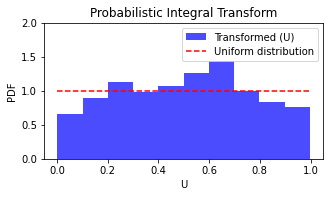

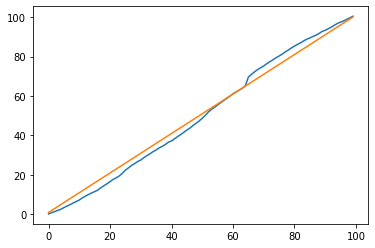

4.70764399316343

In [29]:
_PIT(np.stack(z_1_), nbins = 10, file_name = '{}_{}_{}-PIT-48.png'.format(t, forget_rate, n_kNNs))
_KS(np.stack(z_1_), nbins = 100)

In [30]:
t           = 144
forget_rate = 2
n_kNNs      = 500
i = 24

z_2_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t)
        
#         f_fc_ts_ = F_fc_ts_[d, t:, a]
#         f_fc_tr_ = F_fc_ts_[d, :t, a]
        
        _model = _fit(F_tr_, F_ts_,
                      forget_rate = forget_rate,
                      n_kNNs      = n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        #for i in range(48):
        _eCDF = ECDF(_model['F_'][:, i])
        if (_eCDF(f_ts_[i]) == 0.) | (_eCDF(f_ts_[i]) == 1.):
            continue
        else:
            #z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_2_.append(_eCDF(f_ts_[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


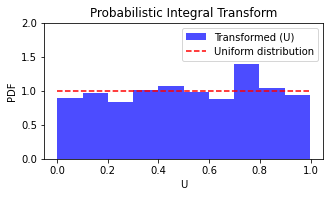

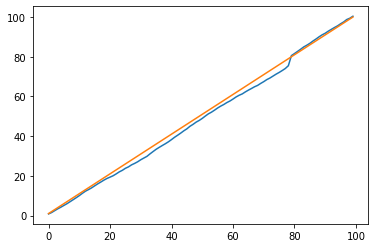

3.959867361862436

In [31]:
_PIT(np.stack(z_2_), nbins = 10, file_name = '{}_{}_{}-PIT-24.png'.format(t, forget_rate, n_kNNs))
_KS(np.stack(z_2_), nbins = 100)

In [32]:
t           = 144
forget_rate = 2
n_kNNs      = 500
i = 12
z_3_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t)
        
        # f_fc_ts_ = F_fc_ts_[d, t:, a]
        # f_fc_tr_ = F_fc_ts_[d, :t, a]
        
        _model = _fit(F_tr_, F_ts_,
                      forget_rate = forget_rate,
                      n_kNNs      = n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)


        #for i in range(48):
        _eCDF = ECDF(_model['F_'][:, i])
        if (_eCDF(f_ts_[i]) == 1.):
            continue
        else:
            #z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_3_.append(_eCDF(f_ts_[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


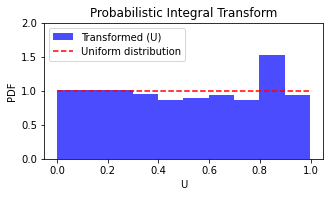

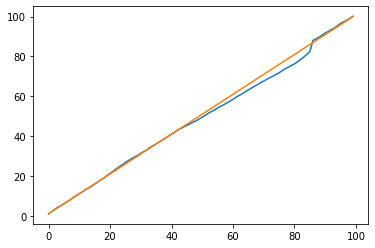

4.725702333503818

In [33]:
_PIT(np.stack(z_3_), nbins = 10, file_name = '{}_{}_{}-PIT-12.png'.format(t, forget_rate, n_kNNs))
_KS(np.stack(z_3_), nbins = 100)

In [34]:
t           = 144
forget_rate = 2
n_kNNs      = 500

i = 60
z_4_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t)
        
        # f_fc_ts_ = F_fc_ts_[d, t:, a]
        # f_fc_tr_ = F_fc_ts_[d, :t, a]
        
        _model = _fit(F_tr_, F_ts_,
                      forget_rate = forget_rate,
                      n_kNNs      = n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)


        #for i in range(36):
        _eCDF = ECDF(_model['F_'][:, i])
        if (_eCDF(f_ts_[i]) == 1.):
            continue
        else:
            #z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_4_.append(_eCDF(f_ts_[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


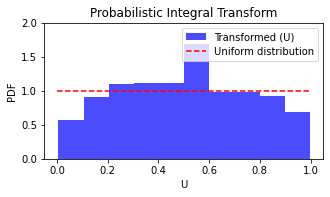

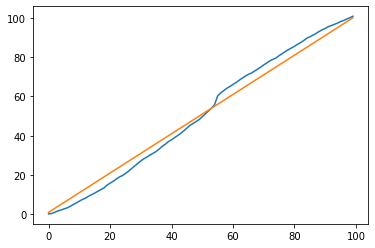

5.577859645969987

In [35]:
_PIT(np.stack(z_4_), nbins = 10, file_name = '{}_{}_{}-PIT-60.png'.format(t, forget_rate, n_kNNs))
_KS(np.stack(z_4_), nbins = 100)

In [ ]:

# # Forecast dynamic update based on distance
# def _ffc_predict(_model, f_, fc_):
    
#     F_ = _model['F_tr_']
    
#     # Smoothing observed mean and actuals
#     if (_model['smoothing'] == 1) | (_model['smoothing'] == 3): 
#         F_, f_ = _smoothing(F_, f_, _model['lambda'])

#     # phi: importance weights based on time distance
#     phi_ = _exponential_decay_minus(f_.shape[0], _model['forget_rate'])
    
#     # plt.figure(figsize = (10, 2))
#     # plt.title('Forget Rate')
#     # plt.plot(phi_)
#     # plt.ylim(-0.1,1.1)
#     # plt.show()

#     # d: euclidian distance between samples weighted by importance weights (phi)
#     d_ = _dist(F_, f_, phi_/phi_.sum())
#     # w: normalized wieghts distance across observations based on RBF kernel distance
#     w_ = _kernel(d_, _model['length_scale'])
        
#     _model['weights'] = w_/w_.sum()
    
#     # Multivariate normal assumption
#     _model = _predictive_multivariate_normal_dist(_model, fc_)

#     return _model

# Multivariate normal forecast assumption
# def _predictive_multivariate_normal_dist(_model, fc_):

#     F_ = _model['F_ts_']
#     w_ = _model['weights']  
    
#     # Mean function
#     f_hat_ = F_.T @ w_ 

#     # Regulate mean function
#     f_hat_ = _gen_constraint(f_hat_, _model['f_min'], _model['f_max'])
    
#     # Smoothing prediction: unobserved mean and actuals
#     if (_model['smoothing'] == 2) | (_model['smoothing'] == 3): 
#         F_, f_hat_ = _smoothing(F_, f_hat_, _model['lambda'])
        
#     # Fuse day-ahead forecast with real-time forecast
#     mu_hat_ = _update_forecast(F_, f_hat_, fc_, _model['trust_rate'])

#     # Covariance function
#     F_hat_ = np.repeat(mu_hat_[:, np.newaxis], F_.shape[0], axis = 1).T
#     S_hat_ = (F_ - F_hat_).T @ np.diag(w_) @ (F_ - F_hat_)
    
#     # plt.figure(figsize = (10, 2))
#     # plt.plot(f_hat_, label = 'real-time (fc)')
#     # plt.plot(fc_, label = 'day-ahead (fc)')
#     # plt.plot(mu_hat_, label = 'update (fc)')
#     # plt.ylim(-0.1,)
#     # plt.legend()
#     # plt.show()

#     # Define probability dist
#     _N = multivariate_normal(mu_hat_, S_hat_, allow_singular = True)
    
#     _model['normal'] = {}
#     _model['normal']['mean']         = mu_hat_
#     _model['normal']['covariance']   = S_hat_
#     _model['normal']['distribution'] = _N
    
#     return _model.copy()